# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [146]:
student1 = "Elias Riedel Gårding"
student2 = "Joey Zenhäusern"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2

Using TensorFlow backend.


### Plotting

In [2]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, label_mapping[j], color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, label_mapping[k], color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [3]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


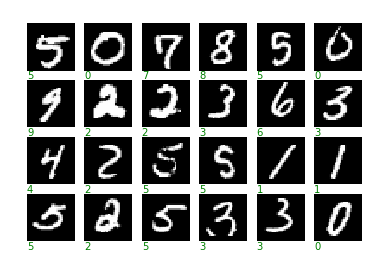

In [4]:
_ = plot_some_samples(x_train, y_train)

Answer to question 2: The green digit below an image with a digit $n$ is the label $n$.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

In [7]:
def get_MNIST():
    return x_train, y_train, x_test, y_test

def get_fashion_MNIST():
    return x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [82]:
def no_layer_model(input_shape):
    model = Sequential()

    model.add(Dense(
        10,
        input_shape=input_shape,
        activation='softmax',
    ))

    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [83]:
models = []
histories = []
for (x_train_, y_train_, x_test_, y_test_) in [get_MNIST(), get_fashion_MNIST()]:
    model = no_layer_model(x_train_.shape[1:])
    histories.append(model.fit(
        x_train_,
        y_train_,
        epochs=20,
        batch_size=128,
        validation_data=(x_test_, y_test_)
    ))
    models.append(model)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 224us/step - loss: 1.2818 - acc: 0.6931 - val_loss: 0.8136 - val_acc: 0.8301
Epoch 2/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.7155 - acc: 0.8399 - val_loss: 0.6085 - val_acc: 0.8634
Epoch 3/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.5872 - acc: 0.8581 - val_loss: 0.5266 - val_acc: 0.8737
Epoch 4/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.5257 - acc: 0.8684 - val_loss: 0.4806 - val_acc: 0.8808
Epoch 5/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.4882 - acc: 0.8750 - val_loss: 0.4510 - val_acc: 0.8867
Epoch 6/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.4624 - acc: 0.8795 - val_loss: 0.4296 - val_acc: 0.8886
Epoch 7/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.4433 - acc: 0.8831 - val_loss: 0.4134 - val_a

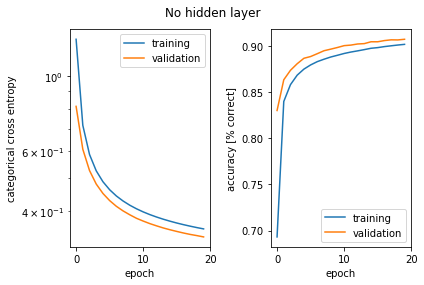

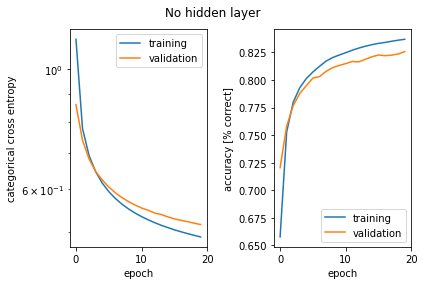

In [84]:
for history in histories:
    _ = plot_history(history, 'No hidden layer')

In [85]:
def classify(model, x):
    """Return the digit."""
    return np.argmax(model.predict(x), axis=1)

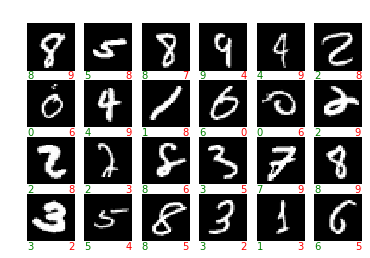

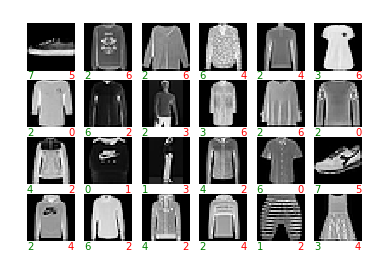

In [86]:
for model, x_test_, y_test_ in zip(models, [x_test, x_fashion_test],
                                   [y_test, y_fashion_test]):
    y_hat = classify(model, x_test_)
    miscl_i = np.nonzero(y_hat != np.argmax(y_test_, axis=1))
    plot_some_samples(x_test_[miscl_i], y_test_[miscl_i], y_hat[miscl_i])

Answer to question 8: Green is label, red is classification result.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [87]:
def ex3_model(dataset):
    x_train_, _, _, _ = dataset
    input_shape = x_train_.shape[1:]

    model = Sequential()

    model.add(Dense(
        128,
        input_shape=input_shape,
        activation='relu',
    ))

    model.add(Dense(
        10,
        activation='softmax',
    ))
    
    return model

ex3_model(get_fashion_MNIST()).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_792 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_793 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [88]:
def compare_optimizers(optimizers, dataset, epochs=20):
    x_train_, y_train_, x_test_, y_test_ = dataset
        
    histories = []
    for optimizer in optimizers:
        model = ex3_model(dataset)
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        histories.append(model.fit(
                x_train_,
                y_train_,
                epochs=epochs,
                batch_size=128,
                validation_data=(x_test_, y_test_)
            ))
        
    return histories

# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [90]:
sgd_history, adam_history = compare_optimizers(['sgd', 'adam'], get_fashion_MNIST(), epochs=40)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 16s 264us/step - loss: 1.0497 - acc: 0.6824 - val_loss: 0.7609 - val_acc: 0.7537
Epoch 2/40
60000/60000 [==============================] - 4s 59us/step - loss: 0.6749 - acc: 0.7858 - val_loss: 0.6459 - val_acc: 0.7855
Epoch 3/40
60000/60000 [==============================] - 4s 59us/step - loss: 0.5940 - acc: 0.8080 - val_loss: 0.5899 - val_acc: 0.8040
Epoch 4/40
60000/60000 [==============================] - 4s 62us/step - loss: 0.5509 - acc: 0.8185 - val_loss: 0.5597 - val_acc: 0.8107
Epoch 5/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.5233 - acc: 0.8263 - val_loss: 0.5381 - val_acc: 0.8189
Epoch 6/40
60000/60000 [==============================] - 4s 60us/step - loss: 0.5037 - acc: 0.8313 - val_loss: 0.5226 - val_acc: 0.8220
Epoch 7/40
60000/60000 [==============================] - 4s 62us/step - loss: 0.4886 - acc: 0.8356 - val_loss: 0.5079 - val_a

Epoch 20/40
60000/60000 [==============================] - 4s 64us/step - loss: 0.2020 - acc: 0.9266 - val_loss: 0.3280 - val_acc: 0.8889
Epoch 21/40
60000/60000 [==============================] - 4s 65us/step - loss: 0.1970 - acc: 0.9284 - val_loss: 0.3391 - val_acc: 0.8841
Epoch 22/40
60000/60000 [==============================] - 4s 67us/step - loss: 0.1940 - acc: 0.9291 - val_loss: 0.3398 - val_acc: 0.8871
Epoch 23/40
60000/60000 [==============================] - 4s 68us/step - loss: 0.1887 - acc: 0.9307 - val_loss: 0.3439 - val_acc: 0.8830
Epoch 24/40
60000/60000 [==============================] - 4s 70us/step - loss: 0.1845 - acc: 0.9317 - val_loss: 0.3321 - val_acc: 0.8892
Epoch 25/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.1790 - acc: 0.9361 - val_loss: 0.3778 - val_acc: 0.8773
Epoch 26/40
60000/60000 [==============================] - 4s 70us/step - loss: 0.1747 - acc: 0.9367 - val_loss: 0.3454 - val_acc: 0.8861
Epoch 27/40
60000/60000 [=========

In [91]:
sgd_history_mnist, adam_history_mnist = compare_optimizers(['sgd', 'adam'], get_MNIST(), epochs=40)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 16s 270us/step - loss: 1.2462 - acc: 0.6958 - val_loss: 0.6577 - val_acc: 0.8568
Epoch 2/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.5577 - acc: 0.8651 - val_loss: 0.4544 - val_acc: 0.8877
Epoch 3/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.4395 - acc: 0.8850 - val_loss: 0.3882 - val_acc: 0.8986
Epoch 4/40
60000/60000 [==============================] - 4s 72us/step - loss: 0.3899 - acc: 0.8944 - val_loss: 0.3534 - val_acc: 0.9051
Epoch 5/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.3604 - acc: 0.9009 - val_loss: 0.3307 - val_acc: 0.9114
Epoch 6/40
60000/60000 [==============================] - 4s 65us/step - loss: 0.3398 - acc: 0.9055 - val_loss: 0.3150 - val_acc: 0.9145
Epoch 7/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.3240 - acc: 0.9098 - val_loss: 0.3020 - val_a

Epoch 20/40
60000/60000 [==============================] - 4s 65us/step - loss: 0.0071 - acc: 0.9987 - val_loss: 0.0751 - val_acc: 0.9795
Epoch 21/40
60000/60000 [==============================] - 4s 64us/step - loss: 0.0063 - acc: 0.9988 - val_loss: 0.0811 - val_acc: 0.9777
Epoch 22/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.0055 - acc: 0.9989 - val_loss: 0.0879 - val_acc: 0.9778
Epoch 23/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.0058 - acc: 0.9987 - val_loss: 0.0794 - val_acc: 0.9800
Epoch 24/40
60000/60000 [==============================] - 4s 64us/step - loss: 0.0047 - acc: 0.9991 - val_loss: 0.0795 - val_acc: 0.9792
Epoch 25/40
60000/60000 [==============================] - 4s 65us/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0782 - val_acc: 0.9801
Epoch 26/40
60000/60000 [==============================] - 4s 67us/step - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0779 - val_acc: 0.9801
Epoch 27/40
60000/60000 [=========

In [92]:
lrs = [1, 0.0001] # SGD learning rates. Default: 0.01
sgd_histories = compare_optimizers([SGD(lr=lr) for lr in lrs], get_fashion_MNIST())

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 266us/step - loss: 2.1693 - acc: 0.1891 - val_loss: 2.2964 - val_acc: 0.0999
Epoch 2/20
60000/60000 [==============================] - 4s 59us/step - loss: 2.2893 - acc: 0.1090 - val_loss: 2.3060 - val_acc: 0.1224
Epoch 3/20
60000/60000 [==============================] - 4s 60us/step - loss: 2.2925 - acc: 0.1081 - val_loss: 2.2482 - val_acc: 0.1003
Epoch 4/20
60000/60000 [==============================] - 4s 62us/step - loss: 2.3069 - acc: 0.1012 - val_loss: 2.3050 - val_acc: 0.1001
Epoch 5/20
60000/60000 [==============================] - 4s 62us/step - loss: 2.3044 - acc: 0.1007 - val_loss: 2.3036 - val_acc: 0.1000
Epoch 6/20
60000/60000 [==============================] - 4s 61us/step - loss: 2.2864 - acc: 0.1070 - val_loss: 2.3043 - val_acc: 0.1000
Epoch 7/20
60000/60000 [==============================] - 4s 62us/step - loss: 2.2777 - acc: 0.1145 - val_loss: 2.3060 - val_a

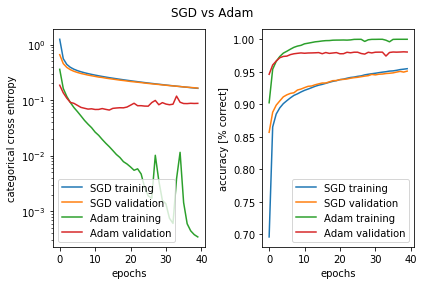

In [93]:
_ = comparison_plot(sgd_history_mnist, adam_history_mnist, "SGD", "Adam", "SGD vs Adam")

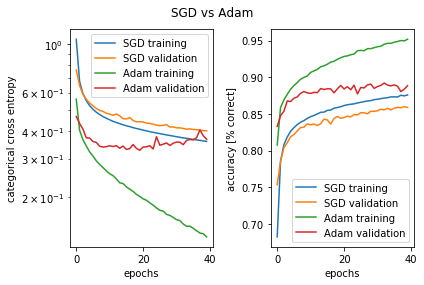

In [94]:
_ = comparison_plot(sgd_history, adam_history, "SGD", "Adam", "SGD vs Adam")

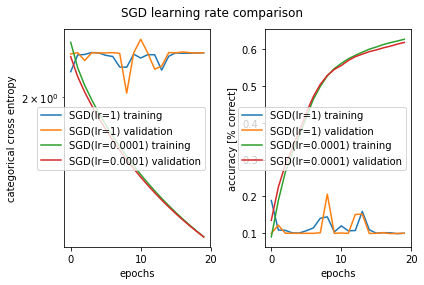

In [95]:
_ = comparison_plot(sgd_histories[0], sgd_histories[1], f"SGD(lr={lrs[0]})", f"SGD(lr={lrs[1]})", "SGD learning rate comparison")

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is small, convergence is much slower.

B) When the learning rate is large, the performance oscillates wildly, but still shows a slight trend towards improvement.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: For MNIST, around epoch 10, where the validation loss starts increasing (~epoch 20 for Fashion-MNIST).

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: The most obvious difference is that loss decreases while accuracy increases as training progresses.
However, loss gives us strictly more information than accuracy.
Validation loss actually starts slowly increasing after a while, while training loss keeps decreasing and validation accuracy reaches a plateau.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [137]:
def get_ex4_histories(dataset, epochs=40):
    x_train_, y_train_, x_test_, y_test_ = dataset
    input_shape = x_train_.shape[1:]
    
    histories = []
    for n_hidden in np.logspace(1, 3, base=10, num=5).round().astype(int):
        # Construct the model
        model = Sequential()
        model.add(Dense(
            n_hidden,
            input_shape=input_shape,
            activation='relu',
        ))
        model.add(Dense(
            10,
            activation='softmax',
        ))
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train it
        histories.append(
            (n_hidden,
             model.fit(x_train_,
                       y_train_,
                       epochs=epochs,
                       batch_size=128,
                       validation_data=(x_test_, y_test_))))
    
    return histories

def ex4_plot(histories, title):
    fig, ax_loss, ax_acc = prepare_standardplot(title, "No. of hidden neurons")
    n_hidden = [n_hidden for n_hidden, _ in histories]
    best_loss = [min(history.history['val_loss']) for _, history in histories]
    best_acc = [max(history.history['val_acc']) for _, history in histories]
    ax_loss.plot(n_hidden, best_loss, '-o')
    ax_acc.plot(n_hidden, best_acc, '-o')
    finalize_standardplot(fig, ax_loss, ax_acc)
    return fig

In [138]:
ex4_mnist_histories = get_ex4_histories(get_MNIST())

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 46us/step - loss: 0.7376 - acc: 0.8004 - val_loss: 0.3882 - val_acc: 0.8950
Epoch 2/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.3592 - acc: 0.9000 - val_loss: 0.3152 - val_acc: 0.9111
Epoch 3/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.3120 - acc: 0.9137 - val_loss: 0.2874 - val_acc: 0.9168
Epoch 4/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.2886 - acc: 0.9194 - val_loss: 0.2758 - val_acc: 0.9212
Epoch 5/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.2741 - acc: 0.9241 - val_loss: 0.2694 - val_acc: 0.9238
Epoch 6/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.2643 - acc: 0.9263 - val_loss: 0.2661 - val_acc: 0.9246
Epoch 7/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.2571 - acc: 0.9277 - val_loss: 0.2581 - val_acc

Epoch 20/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.0594 - acc: 0.9827 - val_loss: 0.1151 - val_acc: 0.9669
Epoch 21/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.0567 - acc: 0.9835 - val_loss: 0.1118 - val_acc: 0.9683
Epoch 22/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.0537 - acc: 0.9845 - val_loss: 0.1106 - val_acc: 0.9690
Epoch 23/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.0510 - acc: 0.9851 - val_loss: 0.1119 - val_acc: 0.9679
Epoch 24/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.0500 - acc: 0.9849 - val_loss: 0.1123 - val_acc: 0.9685
Epoch 25/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.0481 - acc: 0.9859 - val_loss: 0.1132 - val_acc: 0.9691
Epoch 26/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.0463 - acc: 0.9862 - val_loss: 0.1114 - val_acc: 0.9683
Epoch 27/40
60000/60000 [=========

60000/60000 [==============================] - 2s 37us/step - loss: 5.6085e-04 - acc: 1.0000 - val_loss: 0.0913 - val_acc: 0.9795
Epoch 40/40
60000/60000 [==============================] - 2s 38us/step - loss: 4.3399e-04 - acc: 1.0000 - val_loss: 0.0933 - val_acc: 0.9800
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 82us/step - loss: 0.2951 - acc: 0.9173 - val_loss: 0.1503 - val_acc: 0.9548
Epoch 2/40
60000/60000 [==============================] - 4s 60us/step - loss: 0.1220 - acc: 0.9650 - val_loss: 0.1058 - val_acc: 0.9683
Epoch 3/40
60000/60000 [==============================] - 4s 61us/step - loss: 0.0824 - acc: 0.9767 - val_loss: 0.0897 - val_acc: 0.9724
Epoch 4/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.0610 - acc: 0.9823 - val_loss: 0.0830 - val_acc: 0.9751
Epoch 5/40
60000/60000 [==============================] - 5s 76us/step - loss: 0.0465 - acc: 0.9865 - val_loss: 0.0696 - val_acc: 

In [139]:
ex4_fashion_mnist_histories = get_ex4_histories(get_fashion_MNIST())

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 53us/step - loss: 0.7842 - acc: 0.7420 - val_loss: 0.5614 - val_acc: 0.8077
Epoch 2/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.5060 - acc: 0.8260 - val_loss: 0.5063 - val_acc: 0.8238
Epoch 3/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.4653 - acc: 0.8383 - val_loss: 0.4806 - val_acc: 0.8315
Epoch 4/40
60000/60000 [==============================] - 2s 29us/step - loss: 0.4417 - acc: 0.8468 - val_loss: 0.4670 - val_acc: 0.8366
Epoch 5/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.4246 - acc: 0.8525 - val_loss: 0.4622 - val_acc: 0.8338
Epoch 6/40
60000/60000 [==============================] - 2s 34us/step - loss: 0.4126 - acc: 0.8564 - val_loss: 0.4617 - val_acc: 0.8351
Epoch 7/40
60000/60000 [==============================] - 2s 39us/step - loss: 0.4047 - acc: 0.8587 - val_loss: 0.4437 - val_acc

Epoch 20/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.2879 - acc: 0.8952 - val_loss: 0.3751 - val_acc: 0.8690
Epoch 21/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.2873 - acc: 0.8959 - val_loss: 0.3693 - val_acc: 0.8715
Epoch 22/40
60000/60000 [==============================] - 2s 31us/step - loss: 0.2863 - acc: 0.8969 - val_loss: 0.3702 - val_acc: 0.8703
Epoch 23/40
60000/60000 [==============================] - 2s 33us/step - loss: 0.2808 - acc: 0.8982 - val_loss: 0.3739 - val_acc: 0.8680
Epoch 24/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.2762 - acc: 0.8999 - val_loss: 0.3687 - val_acc: 0.8711
Epoch 25/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.2730 - acc: 0.9009 - val_loss: 0.3681 - val_acc: 0.8695
Epoch 26/40
60000/60000 [==============================] - 2s 32us/step - loss: 0.2725 - acc: 0.9000 - val_loss: 0.3705 - val_acc: 0.8719
Epoch 27/40
60000/60000 [=========

60000/60000 [==============================] - 2s 41us/step - loss: 0.1450 - acc: 0.9473 - val_loss: 0.3663 - val_acc: 0.8900
Epoch 40/40
60000/60000 [==============================] - 2s 41us/step - loss: 0.1436 - acc: 0.9466 - val_loss: 0.3623 - val_acc: 0.8899
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 87us/step - loss: 0.5250 - acc: 0.8167 - val_loss: 0.4521 - val_acc: 0.8392
Epoch 2/40
60000/60000 [==============================] - 4s 62us/step - loss: 0.3799 - acc: 0.8654 - val_loss: 0.3942 - val_acc: 0.8583
Epoch 3/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.3461 - acc: 0.8760 - val_loss: 0.3588 - val_acc: 0.8723
Epoch 4/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.3165 - acc: 0.8856 - val_loss: 0.3716 - val_acc: 0.8661
Epoch 5/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.2974 - acc: 0.8919 - val_loss: 0.3465 - val_acc: 0.8732
E

Epoch 18/40
60000/60000 [==============================] - 8s 142us/step - loss: 0.1626 - acc: 0.9393 - val_loss: 0.3539 - val_acc: 0.8885
Epoch 19/40
60000/60000 [==============================] - 8s 133us/step - loss: 0.1586 - acc: 0.9409 - val_loss: 0.3356 - val_acc: 0.8901
Epoch 20/40
60000/60000 [==============================] - 8s 141us/step - loss: 0.1522 - acc: 0.9431 - val_loss: 0.3276 - val_acc: 0.8958
Epoch 21/40
60000/60000 [==============================] - 8s 125us/step - loss: 0.1462 - acc: 0.9449 - val_loss: 0.3185 - val_acc: 0.8959
Epoch 22/40
60000/60000 [==============================] - 7s 124us/step - loss: 0.1410 - acc: 0.9469 - val_loss: 0.3347 - val_acc: 0.8961
Epoch 23/40
60000/60000 [==============================] - 7s 122us/step - loss: 0.1362 - acc: 0.9492 - val_loss: 0.3591 - val_acc: 0.8947
Epoch 24/40
60000/60000 [==============================] - 7s 123us/step - loss: 0.1312 - acc: 0.9511 - val_loss: 0.3471 - val_acc: 0.8940
Epoch 25/40
60000/60000 [==

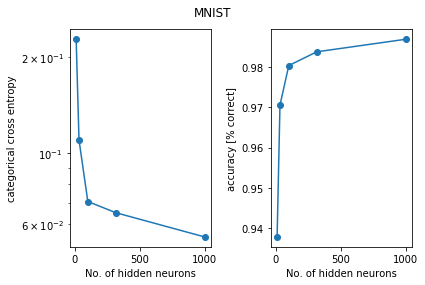

In [148]:
_ = ex4_plot(ex4_mnist_histories, "MNIST")

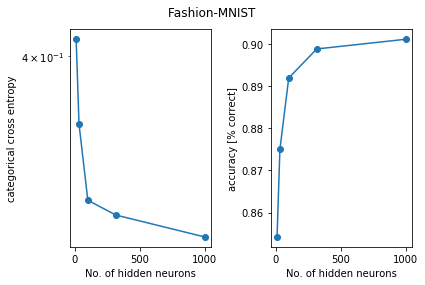

In [141]:
_ = ex4_plot(ex4_fashion_mnist_histories, "Fashion-MNIST")

Answer to question 2:

The Universal Approximation Theorem says only that for any desired approximation error $\varepsilon > 0$, there exists a single-layer network of size $N(\varepsilon)$ that achieves it. It says nothing about the form of $N(\varepsilon)$ other than that it is nondecreasing as $\varepsilon \to 0$, and doesn't say whether—or how fast—this network can be learned using gradient descent.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [56]:
input_shape = get_fashion_MNIST[0].shape[1:]

def get_ex5_model(
    regularizer = None,
    dropout = False,
    batch_normalization = False,
    data = None
    ):
    
    ex5_model = Sequential()
    dropout_rate = 0.5
    
    # first hidden layer
    if batch_normalization:
        ex5_model.add(BatchNormalization())
    ex5_model.add(Dense(
        50,
        input_shape=input_shape,
        activation='relu',
        kernel_regularizer=regularizer,
        bias_regularizer=regularizer,
    ))
    if dropout:
        ex5_model.add(Dropout(rate=dropout_rate))
    
    # second hidden layer
    if batch_normalization:
        ex5_model.add(BatchNormalization())
    ex5_model.add(Dense(
        50,
        activation='relu',
        kernel_regularizer=regularizer,
        bias_regularizer=regularizer,
    ))
    if dropout:
        ex5_model.add(Dropout(rate=dropout_rate))
    
    
    ex5_model.add(Dense(
        10,
        activation='softmax',
    ))
    
    return ex5_model

In [18]:
def train_ex5_model(model, epochs=100, batch_size=128, data=None):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    if data is None:
        data = get_fashion_MNIST()

    x_train = data[0]
    y_train = data[1]
    x_test = data[2]
    y_test = data[3]
    
    return model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test)
    )

In [71]:
# Search for better model
regularizers = [None, l1(0.001), l2(0.001)]
dropout_modes = [False, True]
batch_normalization_modes = [False, True]

histories = {}
epochs = 100
for regularizer in regularizers:
    for dropout_mode in dropout_modes:
        for batch_normalization_mode in batch_normalization_modes:
            model = get_ex5_model(regularizer, dropout_mode, batch_normalization_mode)
            if regularizer is None:
                model_str = "l1={:.3f}, l2={:.3f}, dropout={}, batch_norm={}".format(
                    0, 0, dropout_mode, batch_normalization_mode
                )
            else: 
                model_str = "l1={:.3f}, l2={:.3f}, dropout={}, batch_norm={}".format(
                    regularizer.l1, regularizer.l2, dropout_mode, batch_normalization_mode
                )
            print(model_str)
            history = train_ex5_model(model, epochs=epochs, batch_size=512)
            histories[model_str] = history
            

l1=0.000, l2=0.000, dropout=False, batch_norm=False
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.8623 - acc: 0.7093 - val_loss: 0.5608 - val_acc: 0.8089
Epoch 2/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.4923 - acc: 0.8308 - val_loss: 0.4817 - val_acc: 0.8344
Epoch 3/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4380 - acc: 0.8476 - val_loss: 0.4487 - val_acc: 0.8417
Epoch 4/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.4082 - acc: 0.8564 - val_loss: 0.4343 - val_acc: 0.8449
Epoch 5/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3873 - acc: 0.8617 - val_loss: 0.4106 - val_acc: 0.8563
Epoch 6/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3728 - acc: 0.8674 - val_loss: 0.4093 - val_acc: 0.8540
Epoch 7/100
60000/60000 [==============================] - 1s 22us/s

60000/60000 [==============================] - 1s 20us/step - loss: 0.1939 - acc: 0.9280 - val_loss: 0.3627 - val_acc: 0.8787
Epoch 60/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1895 - acc: 0.9299 - val_loss: 0.3588 - val_acc: 0.8785
Epoch 61/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1876 - acc: 0.9307 - val_loss: 0.3587 - val_acc: 0.8777
Epoch 62/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1863 - acc: 0.9311 - val_loss: 0.3686 - val_acc: 0.8766
Epoch 63/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.1837 - acc: 0.9327 - val_loss: 0.3715 - val_acc: 0.8755
Epoch 64/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.1847 - acc: 0.9321 - val_loss: 0.3665 - val_acc: 0.8799
Epoch 65/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.1829 - acc: 0.9325 - val_loss: 0.3746 - val_acc: 0.8771
Epoch 66/100
60000/60000 [==============

60000/60000 [==============================] - 2s 28us/step - loss: 0.1934 - acc: 0.9291 - val_loss: 0.3543 - val_acc: 0.8785
Epoch 18/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1882 - acc: 0.9303 - val_loss: 0.3696 - val_acc: 0.8737
Epoch 19/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1849 - acc: 0.9321 - val_loss: 0.3641 - val_acc: 0.8783
Epoch 20/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1750 - acc: 0.9356 - val_loss: 0.3622 - val_acc: 0.8784
Epoch 21/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1719 - acc: 0.9364 - val_loss: 0.3687 - val_acc: 0.8806
Epoch 22/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1659 - acc: 0.9395 - val_loss: 0.3771 - val_acc: 0.8786
Epoch 23/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1626 - acc: 0.9405 - val_loss: 0.3776 - val_acc: 0.8790
Epoch 24/100
60000/60000 [==============

60000/60000 [==============================] - 2s 29us/step - loss: 0.0593 - acc: 0.9788 - val_loss: 0.6380 - val_acc: 0.8685
Epoch 77/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.0628 - acc: 0.9773 - val_loss: 0.6515 - val_acc: 0.8702
Epoch 78/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.0610 - acc: 0.9776 - val_loss: 0.6593 - val_acc: 0.8703
Epoch 79/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.0644 - acc: 0.9767 - val_loss: 0.6436 - val_acc: 0.8695
Epoch 80/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.0593 - acc: 0.9782 - val_loss: 0.6477 - val_acc: 0.8718
Epoch 81/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.0585 - acc: 0.9790 - val_loss: 0.6580 - val_acc: 0.8718
Epoch 82/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0591 - acc: 0.9788 - val_loss: 0.6614 - val_acc: 0.8713
Epoch 83/100
60000/60000 [==============

60000/60000 [==============================] - 1s 22us/step - loss: 0.4944 - acc: 0.8271 - val_loss: 0.4052 - val_acc: 0.8567
Epoch 35/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4948 - acc: 0.8278 - val_loss: 0.4009 - val_acc: 0.8572
Epoch 36/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.4921 - acc: 0.8267 - val_loss: 0.4055 - val_acc: 0.8587
Epoch 37/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4920 - acc: 0.8276 - val_loss: 0.3998 - val_acc: 0.8581
Epoch 38/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4887 - acc: 0.8269 - val_loss: 0.3982 - val_acc: 0.8593
Epoch 39/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4915 - acc: 0.8270 - val_loss: 0.4030 - val_acc: 0.8608
Epoch 40/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.4887 - acc: 0.8271 - val_loss: 0.3934 - val_acc: 0.8598
Epoch 41/100
60000/60000 [==============

60000/60000 [==============================] - 1s 22us/step - loss: 0.4475 - acc: 0.8413 - val_loss: 0.4006 - val_acc: 0.8624
Epoch 94/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4450 - acc: 0.8408 - val_loss: 0.3913 - val_acc: 0.8615
Epoch 95/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4445 - acc: 0.8421 - val_loss: 0.3938 - val_acc: 0.8598
Epoch 96/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4482 - acc: 0.8425 - val_loss: 0.3928 - val_acc: 0.8631
Epoch 97/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4452 - acc: 0.8426 - val_loss: 0.4004 - val_acc: 0.8594
Epoch 98/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4436 - acc: 0.8420 - val_loss: 0.3955 - val_acc: 0.8608
Epoch 99/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4474 - acc: 0.8405 - val_loss: 0.3990 - val_acc: 0.8607
Epoch 100/100
60000/60000 [=============

60000/60000 [==============================] - 2s 32us/step - loss: 0.4416 - acc: 0.8451 - val_loss: 0.3834 - val_acc: 0.8637
Epoch 52/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.4362 - acc: 0.8447 - val_loss: 0.3893 - val_acc: 0.8645
Epoch 53/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4349 - acc: 0.8479 - val_loss: 0.3786 - val_acc: 0.8668
Epoch 54/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4332 - acc: 0.8478 - val_loss: 0.3832 - val_acc: 0.8689
Epoch 55/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4357 - acc: 0.8466 - val_loss: 0.3827 - val_acc: 0.8679
Epoch 56/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4323 - acc: 0.8463 - val_loss: 0.3841 - val_acc: 0.8656
Epoch 57/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.4330 - acc: 0.8482 - val_loss: 0.3862 - val_acc: 0.8647
Epoch 58/100
60000/60000 [==============

60000/60000 [==============================] - 1s 21us/step - loss: 0.7589 - acc: 0.8384 - val_loss: 0.7887 - val_acc: 0.8170
Epoch 10/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.7426 - acc: 0.8372 - val_loss: 0.7717 - val_acc: 0.8231
Epoch 11/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.7279 - acc: 0.8406 - val_loss: 0.7462 - val_acc: 0.8311
Epoch 12/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.7146 - acc: 0.8397 - val_loss: 0.7890 - val_acc: 0.8200
Epoch 13/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.7057 - acc: 0.8410 - val_loss: 0.7251 - val_acc: 0.8300
Epoch 14/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.6907 - acc: 0.8442 - val_loss: 0.7115 - val_acc: 0.8340
Epoch 15/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6790 - acc: 0.8443 - val_loss: 0.7002 - val_acc: 0.8337
Epoch 16/100
60000/60000 [==============

60000/60000 [==============================] - 1s 22us/step - loss: 0.5393 - acc: 0.8583 - val_loss: 0.5930 - val_acc: 0.8386
Epoch 69/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5395 - acc: 0.8583 - val_loss: 0.5690 - val_acc: 0.8460
Epoch 70/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.5370 - acc: 0.8595 - val_loss: 0.5832 - val_acc: 0.8410
Epoch 71/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5332 - acc: 0.8596 - val_loss: 0.5690 - val_acc: 0.8499
Epoch 72/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5343 - acc: 0.8595 - val_loss: 0.5786 - val_acc: 0.8449
Epoch 73/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5353 - acc: 0.8588 - val_loss: 0.5781 - val_acc: 0.8425
Epoch 74/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.5297 - acc: 0.8604 - val_loss: 0.5631 - val_acc: 0.8508
Epoch 75/100
60000/60000 [==============

60000/60000 [==============================] - 2s 30us/step - loss: 0.4731 - acc: 0.8858 - val_loss: 0.5509 - val_acc: 0.8591
Epoch 27/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.4687 - acc: 0.8855 - val_loss: 0.5319 - val_acc: 0.8645
Epoch 28/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.4734 - acc: 0.8829 - val_loss: 0.5575 - val_acc: 0.8531
Epoch 29/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4654 - acc: 0.8859 - val_loss: 0.5254 - val_acc: 0.8702
Epoch 30/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4650 - acc: 0.8856 - val_loss: 0.5281 - val_acc: 0.8632
Epoch 31/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.4600 - acc: 0.8862 - val_loss: 0.5443 - val_acc: 0.8596
Epoch 32/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4635 - acc: 0.8845 - val_loss: 0.5406 - val_acc: 0.8569
Epoch 33/100
60000/60000 [==============

Epoch 85/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.4017 - acc: 0.8957 - val_loss: 0.4880 - val_acc: 0.8702
Epoch 86/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.4057 - acc: 0.8937 - val_loss: 0.4760 - val_acc: 0.8741
Epoch 87/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.3995 - acc: 0.8966 - val_loss: 0.4780 - val_acc: 0.8726
Epoch 88/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.4060 - acc: 0.8946 - val_loss: 0.4784 - val_acc: 0.8739
Epoch 89/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.3976 - acc: 0.8957 - val_loss: 0.4674 - val_acc: 0.8748
Epoch 90/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.4014 - acc: 0.8947 - val_loss: 0.4803 - val_acc: 0.8698
Epoch 91/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.3989 - acc: 0.8961 - val_loss: 0.4828 - val_acc: 0.8708
Epoch 92/100
60000/60000 [=

60000/60000 [==============================] - 1s 23us/step - loss: 0.9264 - acc: 0.7664 - val_loss: 0.7434 - val_acc: 0.8259
Epoch 44/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.9322 - acc: 0.7673 - val_loss: 0.7724 - val_acc: 0.8202
Epoch 45/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9245 - acc: 0.7682 - val_loss: 0.7519 - val_acc: 0.8193
Epoch 46/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9284 - acc: 0.7665 - val_loss: 0.7629 - val_acc: 0.8220
Epoch 47/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9271 - acc: 0.7663 - val_loss: 0.7575 - val_acc: 0.8230
Epoch 48/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.9200 - acc: 0.7678 - val_loss: 0.7507 - val_acc: 0.8253
Epoch 49/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.9286 - acc: 0.7655 - val_loss: 0.7623 - val_acc: 0.8202
Epoch 50/100
60000/60000 [==============

60000/60000 [==============================] - 13s 217us/step - loss: 2.8986 - acc: 0.5323 - val_loss: 1.7986 - val_acc: 0.7853
Epoch 2/100
60000/60000 [==============================] - 2s 34us/step - loss: 1.6253 - acc: 0.7069 - val_loss: 1.2365 - val_acc: 0.8095
Epoch 3/100
60000/60000 [==============================] - 2s 32us/step - loss: 1.2433 - acc: 0.7436 - val_loss: 1.0164 - val_acc: 0.8107
Epoch 4/100
60000/60000 [==============================] - 2s 32us/step - loss: 1.1182 - acc: 0.7579 - val_loss: 0.9183 - val_acc: 0.8176
Epoch 5/100
60000/60000 [==============================] - 2s 34us/step - loss: 1.0489 - acc: 0.7677 - val_loss: 0.8505 - val_acc: 0.8266
Epoch 6/100
60000/60000 [==============================] - 2s 33us/step - loss: 1.0017 - acc: 0.7744 - val_loss: 0.8279 - val_acc: 0.8261
Epoch 7/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.9643 - acc: 0.7791 - val_loss: 0.7951 - val_acc: 0.8303
Epoch 8/100
60000/60000 [===================

60000/60000 [==============================] - 2s 30us/step - loss: 0.7337 - acc: 0.8063 - val_loss: 0.6080 - val_acc: 0.8413
Epoch 61/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.7379 - acc: 0.8048 - val_loss: 0.6042 - val_acc: 0.8438
Epoch 62/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.7296 - acc: 0.8072 - val_loss: 0.6122 - val_acc: 0.8376
Epoch 63/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.7239 - acc: 0.8064 - val_loss: 0.5999 - val_acc: 0.8420
Epoch 64/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.7261 - acc: 0.8070 - val_loss: 0.6311 - val_acc: 0.8316
Epoch 65/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.7321 - acc: 0.8074 - val_loss: 0.6110 - val_acc: 0.8375
Epoch 66/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.7244 - acc: 0.8075 - val_loss: 0.5972 - val_acc: 0.8417
Epoch 67/100
60000/60000 [==============

60000/60000 [==============================] - 1s 21us/step - loss: 0.4126 - acc: 0.8834 - val_loss: 0.4701 - val_acc: 0.8626
Epoch 19/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.4038 - acc: 0.8855 - val_loss: 0.4711 - val_acc: 0.8615
Epoch 20/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3987 - acc: 0.8871 - val_loss: 0.4583 - val_acc: 0.8661
Epoch 21/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.4024 - acc: 0.8863 - val_loss: 0.4662 - val_acc: 0.8578
Epoch 22/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3953 - acc: 0.8878 - val_loss: 0.4713 - val_acc: 0.8592
Epoch 23/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3928 - acc: 0.8894 - val_loss: 0.4599 - val_acc: 0.8627
Epoch 24/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.3901 - acc: 0.8902 - val_loss: 0.4473 - val_acc: 0.8674
Epoch 25/100
60000/60000 [==============

60000/60000 [==============================] - 1s 21us/step - loss: 0.3195 - acc: 0.9098 - val_loss: 0.4177 - val_acc: 0.8761
Epoch 78/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3159 - acc: 0.9118 - val_loss: 0.4058 - val_acc: 0.8784
Epoch 79/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3151 - acc: 0.9113 - val_loss: 0.4092 - val_acc: 0.8786
Epoch 80/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3129 - acc: 0.9132 - val_loss: 0.4189 - val_acc: 0.8749
Epoch 81/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.3135 - acc: 0.9133 - val_loss: 0.4144 - val_acc: 0.8760
Epoch 82/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3105 - acc: 0.9144 - val_loss: 0.4060 - val_acc: 0.8776
Epoch 83/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.3141 - acc: 0.9111 - val_loss: 0.4024 - val_acc: 0.8802
Epoch 84/100
60000/60000 [==============

60000/60000 [==============================] - 2s 31us/step - loss: 0.2258 - acc: 0.9395 - val_loss: 0.4370 - val_acc: 0.8754
Epoch 36/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.2220 - acc: 0.9401 - val_loss: 0.4352 - val_acc: 0.8755
Epoch 37/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2269 - acc: 0.9391 - val_loss: 0.4334 - val_acc: 0.8789
Epoch 38/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2214 - acc: 0.9411 - val_loss: 0.4505 - val_acc: 0.8712
Epoch 39/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2185 - acc: 0.9421 - val_loss: 0.4432 - val_acc: 0.8753
Epoch 40/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2146 - acc: 0.9441 - val_loss: 0.4547 - val_acc: 0.8703
Epoch 41/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.2147 - acc: 0.9448 - val_loss: 0.4533 - val_acc: 0.8780
Epoch 42/100
60000/60000 [==============

60000/60000 [==============================] - 2s 33us/step - loss: 0.1796 - acc: 0.9582 - val_loss: 0.5248 - val_acc: 0.8750
Epoch 95/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1690 - acc: 0.9631 - val_loss: 0.5380 - val_acc: 0.8756
Epoch 96/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1758 - acc: 0.9613 - val_loss: 0.5277 - val_acc: 0.8774
Epoch 97/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1767 - acc: 0.9601 - val_loss: 0.5332 - val_acc: 0.8725
Epoch 98/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1675 - acc: 0.9641 - val_loss: 0.5401 - val_acc: 0.8737
Epoch 99/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.1740 - acc: 0.9603 - val_loss: 0.5416 - val_acc: 0.8740
Epoch 100/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1746 - acc: 0.9603 - val_loss: 0.5541 - val_acc: 0.8738
l1=0.000, l2=0.001, dropout=True, batch

60000/60000 [==============================] - 1s 24us/step - loss: 0.5862 - acc: 0.8201 - val_loss: 0.4774 - val_acc: 0.8547
Epoch 53/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5829 - acc: 0.8224 - val_loss: 0.4820 - val_acc: 0.8546
Epoch 54/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5855 - acc: 0.8203 - val_loss: 0.4839 - val_acc: 0.8555
Epoch 55/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5788 - acc: 0.8220 - val_loss: 0.4716 - val_acc: 0.8532
Epoch 56/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.5832 - acc: 0.8221 - val_loss: 0.4800 - val_acc: 0.8522
Epoch 57/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.5840 - acc: 0.8204 - val_loss: 0.4720 - val_acc: 0.8561
Epoch 58/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.5810 - acc: 0.8219 - val_loss: 0.4734 - val_acc: 0.8569
Epoch 59/100
60000/60000 [==============

60000/60000 [==============================] - 2s 32us/step - loss: 0.6298 - acc: 0.8120 - val_loss: 0.5040 - val_acc: 0.8466
Epoch 11/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.6115 - acc: 0.8178 - val_loss: 0.4920 - val_acc: 0.8451
Epoch 12/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.6066 - acc: 0.8207 - val_loss: 0.4894 - val_acc: 0.8510
Epoch 13/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.5982 - acc: 0.8207 - val_loss: 0.4772 - val_acc: 0.8522
Epoch 14/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.5935 - acc: 0.8225 - val_loss: 0.4698 - val_acc: 0.8535
Epoch 15/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.5879 - acc: 0.8224 - val_loss: 0.4756 - val_acc: 0.8549
Epoch 16/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.5836 - acc: 0.8248 - val_loss: 0.4748 - val_acc: 0.8529
Epoch 17/100
60000/60000 [==============

60000/60000 [==============================] - 2s 32us/step - loss: 0.5205 - acc: 0.8341 - val_loss: 0.4354 - val_acc: 0.8601
Epoch 70/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5181 - acc: 0.8352 - val_loss: 0.4377 - val_acc: 0.8608
Epoch 71/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5168 - acc: 0.8365 - val_loss: 0.4417 - val_acc: 0.8565
Epoch 72/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5210 - acc: 0.8335 - val_loss: 0.4353 - val_acc: 0.8608
Epoch 73/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5189 - acc: 0.8336 - val_loss: 0.4363 - val_acc: 0.8592
Epoch 74/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5178 - acc: 0.8358 - val_loss: 0.4349 - val_acc: 0.8618
Epoch 75/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.5123 - acc: 0.8361 - val_loss: 0.4362 - val_acc: 0.8616
Epoch 76/100
60000/60000 [==============

In [75]:
# Search for best model
sorted_histories = sorted(histories.items(), key=lambda entry: entry[1].history['val_loss'][-1])
for history_str, history in sorted_histories:
    print("Accuracy: {:.3f}, Loss: {:.3f} | {}".format(
        history.history['val_acc'][-1],
        history.history['val_loss'][-1],
        history_str))

Accuracy: 0.869, Loss: 0.385 | l1=0.000, l2=0.000, dropout=True, batch_norm=True
Accuracy: 0.865, Loss: 0.393 | l1=0.000, l2=0.000, dropout=True, batch_norm=False
Accuracy: 0.880, Loss: 0.398 | l1=0.000, l2=0.001, dropout=False, batch_norm=False
Accuracy: 0.880, Loss: 0.421 | l1=0.000, l2=0.000, dropout=False, batch_norm=False
Accuracy: 0.858, Loss: 0.441 | l1=0.000, l2=0.001, dropout=True, batch_norm=True
Accuracy: 0.871, Loss: 0.467 | l1=0.001, l2=0.000, dropout=False, batch_norm=True
Accuracy: 0.854, Loss: 0.470 | l1=0.000, l2=0.001, dropout=True, batch_norm=False
Accuracy: 0.874, Loss: 0.554 | l1=0.000, l2=0.001, dropout=False, batch_norm=True
Accuracy: 0.844, Loss: 0.557 | l1=0.001, l2=0.000, dropout=False, batch_norm=False
Accuracy: 0.841, Loss: 0.593 | l1=0.001, l2=0.000, dropout=True, batch_norm=True
Accuracy: 0.816, Loss: 0.729 | l1=0.001, l2=0.000, dropout=True, batch_norm=False
Accuracy: 0.870, Loss: 0.746 | l1=0.000, l2=0.000, dropout=False, batch_norm=True


Exercise 5 - No Tricks
Loss: 0.344075 (validation), 0.145046 (training)
Accuracy: 0.8824 (validation), 0.946517 (training)

Exercise 5 - Improved Model
Loss: 0.378637 (validation), 0.410744 (training)
Accuracy: 0.8721 (validation), 0.853667 (training)



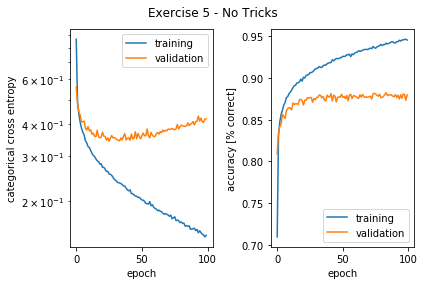

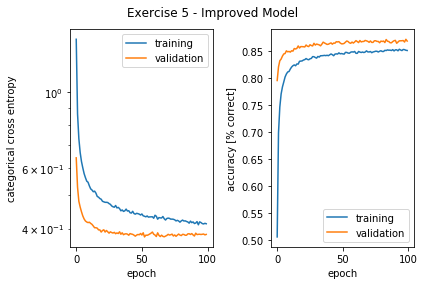

In [81]:
for title, history in {
    "Exercise 5 - No Tricks": histories["l1=0.000, l2=0.000, dropout=False, batch_norm=False"], 
    "Exercise 5 - Improved Model": histories["l1=0.000, l2=0.000, dropout=True, batch_norm=True"]
}.items():
    _ = plot_history(history, title)
    print(title)
    print("Loss: {:g} (validation), {:g} (training)".format(min(history.history['val_loss']), min(history.history['loss'])))
    print("Accuracy: {:g} (validation), {:g} (training)".format(max(history.history['val_acc']), max(history.history['acc'])))
    print()


Answer to question 2 (comments):

The best-performing network was one with dropout after and batch normalization before both
hidden layers, but the improvement over the naive network was minor (best validation loss 0.385 versus 0.421, while accuracy actually decreased by 0.011).

In [96]:
# For regular MNIST
ex5_reg_mnist = get_ex5_model()
ex5_history_reg_mnist = train_ex5_model(model, epochs=100, batch_size=512, data=get_MNIST())

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s 226us/step - loss: 1.8464 - acc: 0.4303 - val_loss: 0.8669 - val_acc: 0.7551
Epoch 2/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.6854 - acc: 0.8139 - val_loss: 0.5409 - val_acc: 0.8584
Epoch 3/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.5017 - acc: 0.8680 - val_loss: 0.4397 - val_acc: 0.8831
Epoch 4/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.4286 - acc: 0.8861 - val_loss: 0.3902 - val_acc: 0.8952
Epoch 5/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.3887 - acc: 0.8951 - val_loss: 0.3607 - val_acc: 0.9054
Epoch 6/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.3628 - acc: 0.9009 - val_loss: 0.3398 - val_acc: 0.9084
Epoch 7/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.3447 - acc: 0.9057 - val_loss: 0.3254 

60000/60000 [==============================] - 1s 17us/step - loss: 0.2384 - acc: 0.9344 - val_loss: 0.2623 - val_acc: 0.9275
Epoch 60/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.2382 - acc: 0.9344 - val_loss: 0.2619 - val_acc: 0.9282
Epoch 61/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.2377 - acc: 0.9347 - val_loss: 0.2611 - val_acc: 0.9280
Epoch 62/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.2375 - acc: 0.9342 - val_loss: 0.2624 - val_acc: 0.9280
Epoch 63/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.2372 - acc: 0.9343 - val_loss: 0.2612 - val_acc: 0.9281
Epoch 64/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.2371 - acc: 0.9346 - val_loss: 0.2618 - val_acc: 0.9281
Epoch 65/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2369 - acc: 0.9347 - val_loss: 0.2622 - val_acc: 0.9283
Epoch 66/100
60000/60000 [==============

Loss: 0.260614 (validation), 0.229167 (training)
Accuracy: 0.9295 (validation), 0.937367 (training)


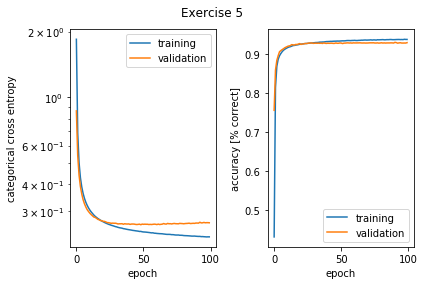

In [97]:
_ = plot_history(ex5_history_reg_mnist, "Exercise 5")
print("Loss: {:g} (validation), {:g} (training)".format(min(ex5_history_reg_mnist.history['val_loss']), min(ex5_history_reg_mnist.history['loss'])))
print("Accuracy: {:g} (validation), {:g} (training)".format(max(ex5_history_reg_mnist.history['val_acc']), max(ex5_history_reg_mnist.history['acc'])))

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [98]:
class CNN:
    def __init__(self, activation='relu', max_depth=2, batch_normalization=False, data=None, dropout=0.1, lr=0.001):
        self.model = Sequential()
        self.activation = activation
        self.dropout = dropout
        self.lr = lr
        
        if data is None:
            self.data = get_MNIST()
        else:
            self.data = data
            
        input_shape = (28, 28, 1)
        self.x_train = self.data[0].reshape(-1, *input_shape)
        self.y_train = self.data[1]
        self.x_test = self.data[2].reshape(-1, *input_shape)
        self.y_test = self.data[3]
        
        # Add convolutional layers
        for d in range(max_depth):
            if batch_normalization:
                self.model.add(BatchNormalization())
            self.model.add(Conv2D(
                filters = 2 ** (d + 2),
                kernel_size = (3, 3),
                activation = self.activation,
                input_shape = input_shape)
            )
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            
        # Dropout
        self.model.add(Dropout(rate = self.dropout))
        
        # Fully connected layers
        self.model.add(Flatten())
        
        if batch_normalization:
            self.model.add(BatchNormalization())
        self.model.add(Dense(y_train.shape[-1], activation = 'softmax'))
        
    def train(self, batch_size=512, epochs=20):
        self.model.compile(
            optimizer = Adam(lr=self.lr),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )
        self.history = self.model.fit(
            self.x_train,
            self.y_train,
            batch_size = batch_size,
            epochs = epochs,
            validation_data = (self.x_test, self.y_test)
        )
        return self.history

In [99]:
model = CNN()
model.train()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 325us/step - loss: 1.4191 - acc: 0.5589 - val_loss: 0.5082 - val_acc: 0.8533
Epoch 2/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.4950 - acc: 0.8431 - val_loss: 0.3067 - val_acc: 0.9119
Epoch 3/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.3470 - acc: 0.8932 - val_loss: 0.2340 - val_acc: 0.9320
Epoch 4/20
60000/60000 [==============================] - 7s 112us/step - loss: 0.2818 - acc: 0.9140 - val_loss: 0.1912 - val_acc: 0.9444
Epoch 5/20
60000/60000 [==============================] - 7s 120us/step - loss: 0.2382 - acc: 0.9283 - val_loss: 0.1654 - val_acc: 0.9519
Epoch 6/20
60000/60000 [==============================] - 7s 112us/step - loss: 0.2135 - acc: 0.9347 - val_loss: 0.1468 - val_acc: 0.9580
Epoch 7/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.1923 - acc: 0.9412 - val_loss: 0.1319 -

In [100]:
model_fashion = CNN(data = get_fashion_MNIST())
model_fashion.train()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 20s 334us/step - loss: 1.5449 - acc: 0.4610 - val_loss: 0.8630 - val_acc: 0.6937
Epoch 2/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.7961 - acc: 0.7098 - val_loss: 0.6747 - val_acc: 0.7568
Epoch 3/20
60000/60000 [==============================] - 7s 113us/step - loss: 0.6714 - acc: 0.7521 - val_loss: 0.6015 - val_acc: 0.7820
Epoch 4/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.6096 - acc: 0.7757 - val_loss: 0.5621 - val_acc: 0.7935
Epoch 5/20
60000/60000 [==============================] - 8s 125us/step - loss: 0.5781 - acc: 0.7871 - val_loss: 0.5398 - val_acc: 0.8050
Epoch 6/20
60000/60000 [==============================] - 8s 133us/step - loss: 0.5537 - acc: 0.7979 - val_loss: 0.5184 - val_acc: 0.8132
Epoch 7/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.5363 - acc: 0.8059 - val_loss: 0.5050 -

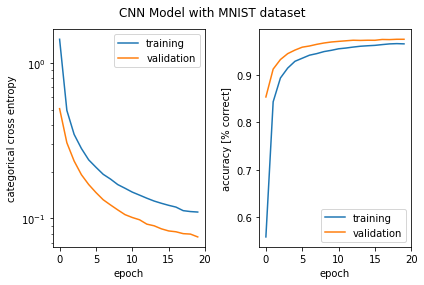

In [101]:
_ = plot_history(model.history, "CNN Model with MNIST dataset")

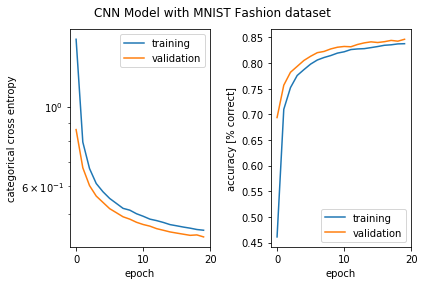

In [103]:
_ = plot_history(model_fashion.history, "CNN Model with MNIST Fashion dataset")

Answer to question 3:

Compared to all previous networks the CNN model converges much faster and achieves very high accuracy. 

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [104]:
cnn_sigmoid = CNN(activation = 'sigmoid')
cnn_sigmoid.train()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 316us/step - loss: 2.3130 - acc: 0.1054 - val_loss: 2.2953 - val_acc: 0.1135
Epoch 2/20
60000/60000 [==============================] - 6s 97us/step - loss: 2.2851 - acc: 0.1437 - val_loss: 2.2391 - val_acc: 0.3601
Epoch 3/20
60000/60000 [==============================] - 6s 95us/step - loss: 2.0001 - acc: 0.4358 - val_loss: 1.4942 - val_acc: 0.7635
Epoch 4/20
60000/60000 [==============================] - 6s 108us/step - loss: 1.0750 - acc: 0.7698 - val_loss: 0.7122 - val_acc: 0.8553
Epoch 5/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.6479 - acc: 0.8393 - val_loss: 0.5013 - val_acc: 0.8825
Epoch 6/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.5104 - acc: 0.8624 - val_loss: 0.4116 - val_acc: 0.8956
Epoch 7/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.4369 - acc: 0.8789 - val_loss: 0.3585 - val

In [105]:
cnn_sigmoid_fashion = CNN(data = get_fashion_MNIST(), activation = 'sigmoid')
cnn_sigmoid_fashion.train()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 313us/step - loss: 2.3131 - acc: 0.1139 - val_loss: 2.2457 - val_acc: 0.2970
Epoch 2/20
60000/60000 [==============================] - 6s 97us/step - loss: 1.9188 - acc: 0.3759 - val_loss: 1.3686 - val_acc: 0.6310
Epoch 3/20
60000/60000 [==============================] - 6s 94us/step - loss: 1.1352 - acc: 0.6254 - val_loss: 0.9691 - val_acc: 0.6864
Epoch 4/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.9284 - acc: 0.6796 - val_loss: 0.8621 - val_acc: 0.7072
Epoch 5/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.8483 - acc: 0.7008 - val_loss: 0.8079 - val_acc: 0.7150
Epoch 6/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.7997 - acc: 0.7163 - val_loss: 0.7721 - val_acc: 0.7259
Epoch 7/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.7669 - acc: 0.7257 - val_loss: 0.7404 - val_a

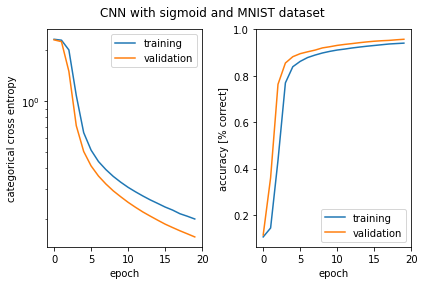

In [106]:
_ = plot_history(cnn_sigmoid.history, "CNN with sigmoid and MNIST dataset")

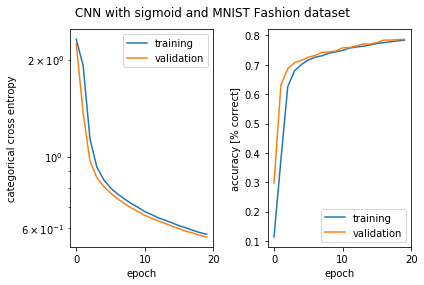

In [107]:
_ = plot_history(cnn_sigmoid_fashion.history, "CNN with sigmoid and MNIST Fashion dataset")

In [108]:
cnn_sigmoid_batch_norm = CNN(data = get_fashion_MNIST(), activation = 'sigmoid', batch_normalization = True)
cnn_sigmoid_batch_norm.train()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 366us/step - loss: 1.4182 - acc: 0.5072 - val_loss: 0.7938 - val_acc: 0.7201
Epoch 2/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.7990 - acc: 0.7076 - val_loss: 0.6635 - val_acc: 0.7517
Epoch 3/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.6619 - acc: 0.7552 - val_loss: 0.5836 - val_acc: 0.7876
Epoch 4/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.5986 - acc: 0.7782 - val_loss: 0.5477 - val_acc: 0.8014
Epoch 5/20
60000/60000 [==============================] - 8s 132us/step - loss: 0.5558 - acc: 0.7953 - val_loss: 0.5229 - val_acc: 0.8059
Epoch 6/20
60000/60000 [==============================] - 8s 125us/step - loss: 0.5248 - acc: 0.8088 - val_loss: 0.5092 - val_acc: 0.8117
Epoch 7/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.5033 - acc: 0.8159 - val_loss: 0.4850 -

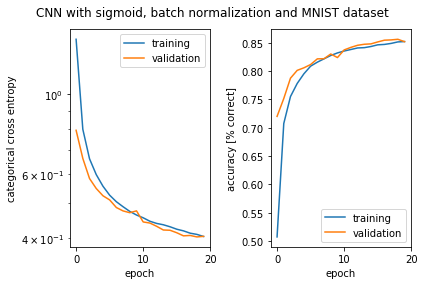

In [109]:
_ = plot_history(cnn_sigmoid_batch_norm.history, "CNN with sigmoid, batch normalization and MNIST dataset")

Answer to question 1:

If we compare with the model using the ReLu we can see that changing to sigmoid reduces the performance of the model (convergence speed and final accuracy) quite a bit.

Answer to question 2:

Adding batch normalization layers to the model improves the speed of convergence, but it still can't reach the performance of the model with ReLu activation.